In [88]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model 
from tensorflow.keras.regularizers import L2
from tensorflow.keras.metrics import Recall
from sklearn.metrics import f1_score

print(tf.__version__)
# https://www.tensorflow.org/tutorials/images/classification

2.12.0


# Multi cell model 
Importing the data and spliting it 

In [61]:
batch_size = 32
img_height = 27
img_width = 27

train_ds = tf.keras.utils.image_dataset_from_directory(
  '/home/fish/programing/cancerClassifier/splitData/',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  '/home/fish/programing/cancerClassifier/splitData/',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names = train_ds.class_names

Found 9896 files belonging to 4 classes.
Using 7917 files for training.
Found 9896 files belonging to 4 classes.
Using 1979 files for validation.


In [62]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



normalising the data to 0 to 1 insted of 0 to 256

In [63]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[10]
# Notice the pixel values are now in `[0,1]`.
print(np.min(fiDefining the model and compiling it rst_image), np.max(first_image))

print(len(image_batch))

0.08627451 1.0
32


2023-05-17 21:20:04.213304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7917]
	 [[{{node Placeholder/_0}}]]
2023-05-17 21:20:04.213670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7917]
	 [[{{node Placeholder/_0}}]]


Defining the model and compiling it 

In [90]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='gelu'),
  layers.Dense(256, activation='gelu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 27, 27, 3)         0         
                                                                 
 conv2d_36 (Conv2D)          (None, 27, 27, 32)        896       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 6, 6, 128)       

In [23]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15
248/248 [==============================] - 4s 12ms/step - loss: 1.1095 - accuracy: 0.5247 - val_loss: 0.8178 - val_accuracy: 0.6913
Epoch 2/15
248/248 [==============================] - 3s 11ms/step - loss: 0.7844 - accuracy: 0.6898 - val_loss: 0.6885 - val_accuracy: 0.7281
Epoch 3/15
248/248 [==============================] - 3s 11ms/step - loss: 0.7355 - accuracy: 0.7044 - val_loss: 0.6710 - val_accuracy: 0.7453
Epoch 4/15
248/248 [==============================] - 3s 11ms/step - loss: 0.6898 - accuracy: 0.7299 - val_loss: 0.6693 - val_accuracy: 0.7418
Epoch 5/15
248/248 [==============================] - 3s 11ms/step - loss: 0.6543 - accuracy: 0.7465 - val_loss: 0.6244 - val_accuracy: 0.7671
Epoch 6/15
248/248 [==============================] - 3s 11ms/step - loss: 0.6238 - accuracy: 0.7574 - val_loss: 0.6916 - val_accuracy: 0.7297
Epoch 7/15
248/248 [==============================] - 3s 11ms/step - loss: 0.6063 - accuracy: 0.7653 - val_loss: 0.6820 - val_accuracy: 0.7342

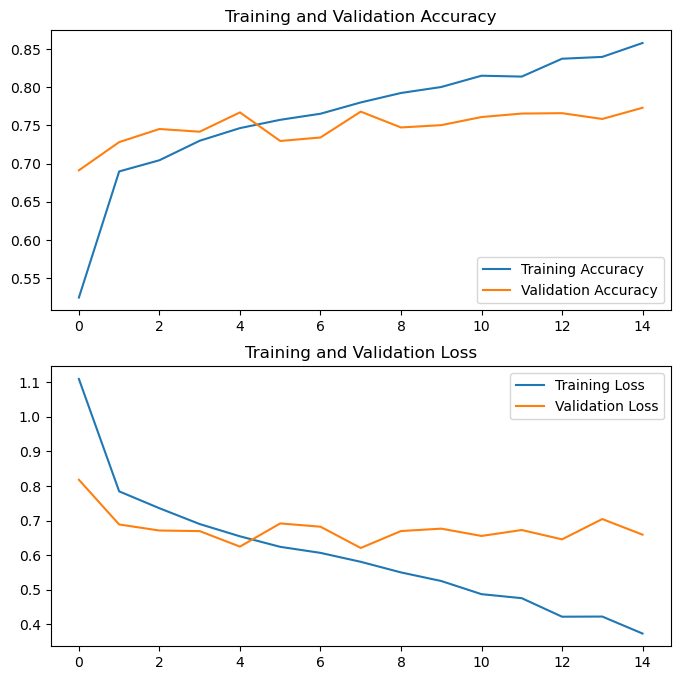

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [19]:
model.save_weights('./checkpoints/multi4')

# Singel model training
importing the data and spliting it 

In [107]:
batch_size = 32
img_height = 27
img_width = 27

train_ds = tf.keras.utils.image_dataset_from_directory(
  '/home/fish/programing/cancerClassifier/cdata/',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  '/home/fish/programing/cancerClassifier/cdata/',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names = train_ds.class_names

Found 20280 files belonging to 2 classes.
Using 16224 files for training.
Found 20280 files belonging to 2 classes.
Using 4056 files for validation.


In [108]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



normalising the data to 0 to 1 insted of 0 to 256

In [109]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[10]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

print(len(image_batch))

2023-05-17 22:14:51.656876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [16224]
	 [[{{node Placeholder/_4}}]]
2023-05-17 22:14:51.657173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [16224]
	 [[{{node Placeholder/_4}}]]


0.16470589 1.0
32


Defining the model and compiling it 

In [100]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='gelu'),
  layers.Dense(256, activation='gelu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='Adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_16 (Rescaling)    (None, 27, 27, 3)         0         
                                                                 
 conv2d_39 (Conv2D)          (None, 27, 27, 32)        896       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 6, 6, 128)       

In [38]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15
507/507 [==============================] - 7s 12ms/step - loss: 0.5839 - accuracy: 0.6952 - val_loss: 0.4450 - val_accuracy: 0.7912
Epoch 2/15
507/507 [==============================] - 6s 12ms/step - loss: 0.4421 - accuracy: 0.7954 - val_loss: 0.3732 - val_accuracy: 0.8289
Epoch 3/15
507/507 [==============================] - 6s 11ms/step - loss: 0.3930 - accuracy: 0.8231 - val_loss: 0.3397 - val_accuracy: 0.8545
Epoch 4/15
507/507 [==============================] - 6s 13ms/step - loss: 0.3570 - accuracy: 0.8426 - val_loss: 0.3187 - val_accuracy: 0.8570
Epoch 5/15
507/507 [==============================] - 6s 12ms/step - loss: 0.3328 - accuracy: 0.8523 - val_loss: 0.3351 - val_accuracy: 0.8489
Epoch 6/15
507/507 [==============================] - 6s 13ms/step - loss: 0.3233 - accuracy: 0.8588 - val_loss: 0.3675 - val_accuracy: 0.8356
Epoch 7/15
507/507 [==============================] - 6s 12ms/step - loss: 0.3031 - accuracy: 0.8687 - val_loss: 0.3695 - val_accuracy: 0.8156

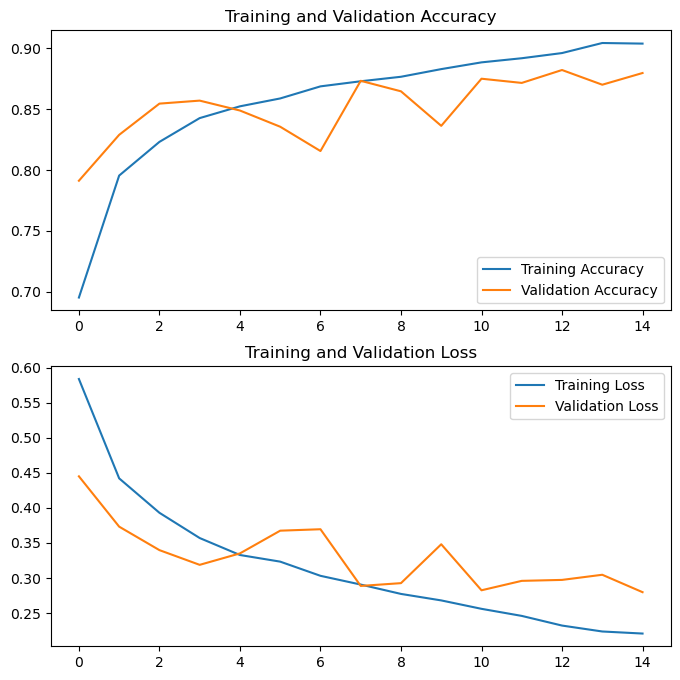

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [40]:
model.save_weights('./checkpoints/c4')

# Metrics
There are 8 models saved 
To import the models use the function below after defigning the models above.
multicell models: ./checkpoints/multi<1,2,3,4> 
iscancer models: ./checkpoints/c<1,2,3,4>

for multi2 or c1 the model will have to be defined with dense layers of size 64 but for all the others 256 is fine. 
 

In [101]:
# Restore the weights
model.load_weights('./checkpoints/c2')

To validate the metrics of a iscancer model use the singel training data and run the below code

In [111]:
out = 0
divs = 0
for batch in val_ds.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    ypred = []
    for i in yhat:
        ypred.append(round(i[0],0))
#     print(y, ypred)
#     print(f1_score(y, ypred, average='weighted'))
    out += f1_score(y, ypred, average='weighted')
    divs += 1

print("f1:", out/divs)


1/1 [==============================] - 0s 14ms/step
f1: 0.8616131211278307


In [113]:
re = Recall()
for batch in val_ds.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    ypred = []
    re.update_state(y, yhat)

print("recall:", re.result())

1/1 [==============================] - 0s 14ms/step
recall: tf.Tensor(0.9209213, shape=(), dtype=float32)


To validate the metrics of a multi cell model use the multi training data and run the below code

In [102]:
re = Recall()
for batch in val_ds.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    ypred = []
    for i in yhat:
        ypred.append(np.argmax(i))
# #     print(y, ypred)
    re.update_state(y, ypred)

print("recall:", re.result())

1/1 [==============================] - 0s 57ms/step
recall: tf.Tensor(0.0, shape=(), dtype=float32)


In [103]:
out = 0
divs = 0
for batch in val_ds.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    ypred = []
    for i in yhat:
        ypred.append(np.argmax(i))
#     print(y, ypred)
#     print(f1_score(y, ypred, average='weighted'))
    out += f1_score(y, ypred, average='weighted')
    divs += 1

print("f1:", out/divs)


1/1 [==============================] - 0s 15ms/step
f1: 0.24645863204189183


# helper things

In [9]:
import shutil
src_path = r"/home/fish/programing/cancerClassifier/patch_images/"
dst_path = r"/home/fish/programing/cancerClassifier/cdata/"

# split the dataset 
# dont runn unless you wanna split the data again (you dont)
with open('data_labels_mainData.csv', 'r') as file:
    
    for line in file.readlines()[1:]:
        li = line.split(',')
        if li[3] == '0\n':
            shutil.copyfile(src_path + str(li[2]), dst_path + 'N' + '/' + str(li[2]))
        else:
            shutil.copyfile(src_path + str(li[2]), dst_path + 'Y' + '/' + str(li[2]))
    
        
        

